***Vasiliy Mosin***

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import os
#thanks @keskarnitish

# Generate names
* Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train NN instead.
* Dataset contains ~8k human names from different cultures[in latin transcript]
* Objective (toy problem): learn a generative model over names.

In [2]:
start_token = " "

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token+name for name in names]

In [3]:
print 'n samples = ',len(names)
for x in names[::1000]:
    print x

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


# Text processing

In [4]:
#all unique characters go here
token_set = set()
for name in names:
    for letter in name:
        token_set.add(letter)

tokens = list(token_set)

print 'n_tokens = ',len(tokens)

n_tokens =  55


In [5]:
#!token_to_id = <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {t:i for i,t in enumerate(tokens) }

#!id_to_token = < dictionary of symbol identifier -> symbol itself>
id_to_token = {i:t for i,t in enumerate(tokens)}

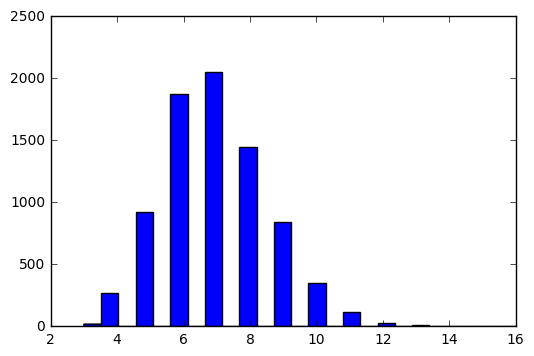

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(map(len,names),bins=25);

# truncate names longer than MAX_LEN characters. 
MAX_LEN = min([60,max(list(map(len,names)))])
#ADJUST IF YOU ARE UP TO SOMETHING SERIOUS

### Cast everything from symbols into identifiers

In [7]:
names_ix = list(map(lambda name: list(map(token_to_id.get,name)),names))


#crop long names and pad short ones
for i in range(len(names_ix)):
    names_ix[i] = names_ix[i][:MAX_LEN] #crop too long
    
    if len(names_ix[i]) < MAX_LEN:
        names_ix[i] += [token_to_id[" "]]*(MAX_LEN - len(names_ix[i])) #pad too short
        
assert len(set(map(len,names_ix)))==1

names_ix = np.array(names_ix)

# Input variables

In [8]:
input_sequence = T.matrix('token sequencea','int32')
target_values = T.matrix('actual next token','int32')

# Build NN

You will be building a model that takes token sequence and predicts next token


* iput sequence
* one-hot / embedding
* recurrent layer(s)
* otput layer(s) that predict output probabilities


In [10]:
from lasagne.layers import InputLayer,DenseLayer,EmbeddingLayer
from lasagne.layers import RecurrentLayer,LSTMLayer,GRULayer,CustomRecurrentLayer

In [11]:
l_in = lasagne.layers.InputLayer(shape=(None, None),input_var=input_sequence)

#!<Your neural network>
l_emb = lasagne.layers.EmbeddingLayer(l_in, len(tokens), 40)

l_rnn = lasagne.layers.RecurrentLayer(l_emb,40,nonlinearity=lasagne.nonlinearities.tanh)

#flatten batch and time to be compatible with feedforward layers (will un-flatten later)
l_rnn_flat = lasagne.layers.reshape(l_rnn, (-1,l_rnn.output_shape[-1]))

l_out = lasagne.layers.DenseLayer(l_rnn_flat,len(tokens), nonlinearity=lasagne.nonlinearities.softmax)

In [12]:
# Model weights
weights = lasagne.layers.get_all_params(l_out,trainable=True)
print weights

[W, input_to_hidden.W, input_to_hidden.b, hidden_to_hidden.W, W, b]


In [13]:
network_output = lasagne.layers.get_output(l_out)
#If you use dropout do not forget to create deterministic version for evaluation

In [14]:
predicted_probabilities_flat = network_output
correct_answers_flat = target_values.ravel()

loss = T.mean(lasagne.objectives.categorical_crossentropy(predicted_probabilities_flat, correct_answers_flat))
#<Loss function - a simple categorical crossentropy will do, maybe add some regularizer>

updates = lasagne.updates.adam(loss,weights)

# Compiling it

In [15]:
#training
train = theano.function([input_sequence, target_values], loss, updates=updates, allow_input_downcast=True)

#computing loss without training
compute_cost = theano.function([input_sequence, target_values], loss, allow_input_downcast=True)

# generation

Simple: 
* get initial context(seed), 
* predict next token probabilities,
* sample next token, 
* add it to the context
* repeat from step 2

You'll get a more detailed info on how it works in the homework section.

In [16]:
#compile the function that computes probabilities for next token given previous text.

#reshape back into original shape
next_word_probas = network_output.reshape((input_sequence.shape[0],input_sequence.shape[1],len(tokens)))
#predictions for next tokens (after sequence end)
last_word_probas = next_word_probas[:,-1]
probs = theano.function([input_sequence],last_word_probas,allow_input_downcast=True)

In [17]:
def generate_sample(seed_phrase=None,N=MAX_LEN,t=1,n_snippets=1):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
        
    parameters:
        sample_fun - max_ or proportional_sample_fun or whatever else you implemented
        
        The phrase is set using the variable seed_phrase

        The optional input "N" is used to set the number of characters of text to predict.     
    '''
    if seed_phrase is None:
        seed_phrase=start_token
    if len(seed_phrase) > MAX_LEN:
        seed_phrase = seed_phrase[-MAX_LEN:]
    assert type(seed_phrase) is str

    snippets = []
    for _ in range(n_snippets):
        sample_ix = []
        x = map(lambda c: token_to_id.get(c,0), seed_phrase)
        x = np.array([x])

        for i in range(N):
            # Pick the character that got assigned the highest probability
            p = probs(x).ravel()
            p = p**t / np.sum(p**t)
            ix = np.random.choice(np.arange(len(tokens)),p=p)
            sample_ix.append(ix)

            x = np.hstack((x[-MAX_LEN+1:],[[ix]]))

        random_snippet = seed_phrase + ''.join(id_to_token[ix] for ix in sample_ix)    
        snippets.append(random_snippet)
        
    print("----\n %s \n----" % '; '.join(snippets))

# Model training

Here you can tweak parameters or insert your generation function


__Once something word-like starts generating, try increasing seq_length__



In [18]:
def sample_batch(data, batch_size):
    
    rows = data[np.random.randint(0,len(data),size=batch_size)]
    
    return rows[:,:-1],rows[:,1:]

In [19]:
print("Training ...")

#total N iterations
n_epochs=100

# how many minibatches are there in the epoch 
batches_per_epoch = 500

#how many training sequences are processed in a single function call
batch_size=10

for epoch in xrange(n_epochs):

    print "Generated names"
    generate_sample(n_snippets=10)

    avg_cost = 0;
    
    for _ in range(batches_per_epoch):
        
        x,y = sample_batch(names_ix,batch_size)
        avg_cost += train(x, y)
        
    print("Epoch {} average loss = {}".format(epoch, avg_cost / batches_per_epoch))

Training ...
Generated names
----
  fmDIvrCVeWLicJFf;  'MEJtooj tHUTiYa;  mDhNZ qmlKxaWIoq;  dUzTRpqbKQdOyBCC;  eXvqhdI'AWE-gwD-;  SwnwSGWwvuiPs-St;  LgVeUPlgBoKeywFV;  'vvzB-i AnJYvipH;  NVLAHpEpnAuSQjub;  be fBfCXfi mpUfT 
----
Epoch 0 average loss = 1.55457510227
Generated names
----
  Jaraa           ;  Aeoara    n     ;  Rwii            ;  Dhry            ;  Menyne       c  ;  Mcg             ;  Daninn          ;  Axotad          ;  Ga            o ;  Eenra            
----
Epoch 1 average loss = 1.17519511991
Generated names
----
  Kernny          ;  Fbylenrvi       ;  Slebme          ;  Deman           ;  Dhasna          ;  Marotsin        ;  Hrahay          ;  Nenk            ;  Siselo          ;  Hudylo           
----
Epoch 2 average loss = 1.128982772
Generated names
----
  Glrha           ;  Kysercal        ;  Maky            ;  Leate           ;  Cerelsad        ;  Cariame         ;  Nasm            ;  Lha             ;  Arsiellaritny   ;  Tadee            
----
Epoch 3 av

In [20]:
generate_sample(n_snippets=10,t=1.5)

----
  Elianna         ;  Regga           ;  Skelle          ;  Dela            ;  Lenn            ;  Melin           ;  Regette         ;  Limon           ;  Tinelle         ;  Stan             
----


In [21]:
generate_sample(seed_phrase=" Putin",n_snippets=100)

----
  Putinea              ;  Putinne              ;  Putinie              ;  Putine               ;  Putine               ;  Putina               ;  Putina               ;  Putine               ;  Putinala             ;  Putine               ;  Putina               ;  Putina               ;  Putine               ;  Putin                ;  Putine               ;  Putina               ;  Putine               ;  Putina               ;  Putine               ;  Putino               ;  Putinand             ;  Putino               ;  Putine               ;  Putine               ;  Putinu               ;  Putine               ;  Putine               ;  Putinoe              ;  Putine               ;  Putina               ;  Putine               ;  Putina               ;  Putina               ;  Putina               ;  Putine               ;  Putine               ;  Putina               ;  Putine               ;  Putine               ;  Putina               ;  Putine               ;  Putin    